# 端点から最大勾配方向へ向かって山登りすることで芯線を求める　両端指定バージョン
[1] から順に実行していってください。（実行は シフトを押しながらEnter）

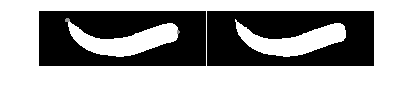

In [2]:
import radishlib as rdl
import cv2
%matplotlib inline
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

# 表示のオンオフ
IMGON = True

# from __future__ import print_function
# 処理対象画像
#srcfile = 'pics/cabumarked.png'
#bwfile = 'pics/cabubw.png'
srcfile = 'pics/horyou2c6kRMarked.jpg'
bwfile = 'pics/horyou2c6kR.jpg'

# 表示のオンオフ
IMGON = True

marks = cv2.imread(srcfile,0)
bw = cv2.imread(bwfile,0)
# jpeg 等の画像は 完全2値化されていないので、念のために2値化しておく
_,bw=cv2.threshold(bw,128,255,cv2.THRESH_BINARY)

# 表示のオンオフ
IMGON = True
rdl.paraimage(marks,bw)

前提として
- 画像は2階調化されている
- 白領域が１つしかない
- 横向きで、左が先
- 同じ画像に対して2点がマークされた画像を用意する。

例
<img src="pics/greendots.jpg" width="450">

[PIXLR]https://pixlr.com/editor/ 

マークは白と黒の中間的な明るさがよい。カラーを使うなら緑色がご抽出されにくい。

最大距離の画像位置(x,y) = ( 2700 , 475 ),  maxR=  203.13


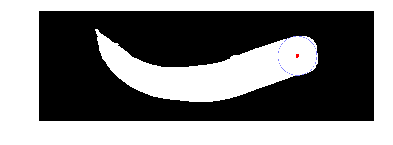

In [3]:
# 距離画像変換　　各白画素について，最も近い黒画素までの距離をデータとする画像を生成
dist = cv2.distanceTransform(bw,cv2.DIST_L2,5)

# 最大の距離は？　　　これが最大半径となる
maxR = np.max(dist)
maxPn = np.argmax(dist)
maxY = int(maxPn/dist.shape[1])
maxX = maxPn - maxY*dist.shape[1]
print("最大距離の画像位置(x,y) = (",maxX, ",",maxY,"),  maxR= ", maxR)

showimg = cv2.cvtColor(bw,cv2.COLOR_GRAY2BGR)
cv2.circle(showimg,(maxX,maxY),maxR,(255,128,128),3)
showimg = cv2.circle(showimg,(maxX,maxY),int(maxR/10),(0,0,255),-1)
rdl.plotimg(showimg)

In [4]:
# 輪郭線データの抽出
ctimg,pts = rdl.getContour(bw,0)

# 確認のための描画
ｃｔx = [i[0][0]  for i in ｐｔｓ[0]]
cty = [i[0][1]  for i in pts[0]]   

# 輪郭データの重複を取り除く
pts =  []
for i in range(len(ctx)):
    if [ctx[i],cty[i]] not in pts:
        pts.append([ctx[i],cty[i]] )
cpts = np.array(pts)

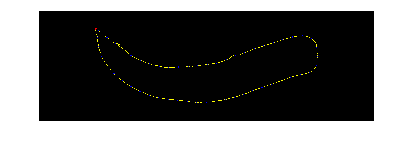

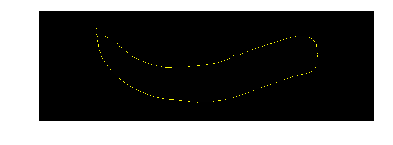

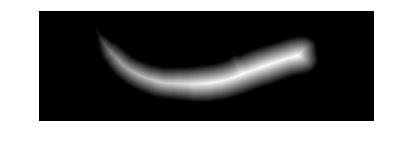

In [5]:
# 確認のために描画
rdl.plotimg(rdl.drawRadishContour(ctimg, cpts, 2,6,10,100,True))
plt.show()

ctrimg = rdl.drawRadishContour(ctimg, cpts)
rdl.plotimg(ctrimg)
plt.show()

# 100は黄色の点の標本間隔、2,6,10　はそれぞれ白、黄色、赤点（開始点）の大きさ

plt.show()
# 参考として距離画像も描画
rdl.plotimg(dist/np.max(dist))

マーク領域を抽出


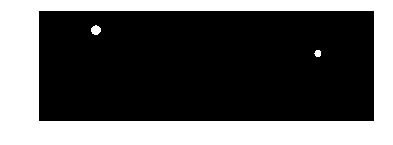

マーク領域と図形の重なり部分のみを抽出


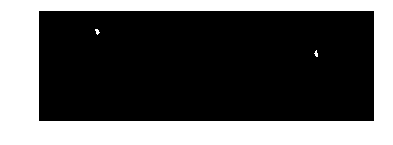

In [6]:
# マーク画像からマークの部分を見つける

_,marks2 =  cv2.threshold(marks, 200,255, cv2.THRESH_TOZERO_INV)
_,marks2 =  cv2.threshold(marks2, 50,255, cv2.THRESH_BINARY)

#　抽出されたマークを確認
print("マーク領域を抽出")
rdl.plotimg(marks2)  
plt.show()

# マーク領域のうち、画像と重なっている部分のみを取り出す
print("マーク領域と図形の重なり部分のみを抽出")
marks3 = cv2.bitwise_and(marks2,bw)
rdl.plotimg(marks3)

In [7]:
# ２つのマークの重心を求める。 
output = cv2.connectedComponentsWithStats(marks3, connectivity = 8)  
centroids = output[3]  # 連結成分の重心のリスト

g1x = int(centroids[1][0])
g1y = int(centroids[1][1])
g2x = int(centroids[2][0])
g2y = int(centroids[2][1])

# 輪郭線データ cpts の中で最も重心に近い点を選ぶ
dtmp = np.ndarray((cpts.shape),dtype=np.uint32)
dtmp = [(g1x - i[0])**2+(g1y - i[1])**2 for i in cpts]
tmpidx = np.argmin(dtmp)
s1x = cpts[tmpidx][0]
s1y = cpts[tmpidx][1]
dtmp = [(g2x - i[0])**2+(g2y - i[1])**2 for i in cpts]
tmpidx = np.argmin(dtmp)
s2x = cpts[tmpidx][0]
s2y = cpts[tmpidx][1]

print("重心1= ({} {}) 　最寄りの輪郭点= ({}, {})  \n重心2= ({} {}) 　最寄りの輪郭点= ({}, {}) ".format(g1x,g1y,s1x,s1y, g2x,g2y,s2x,s2y ))

重心1= (608 223) 　最寄りの輪郭点= (593, 223)  
重心2= (2896 453) 　最寄りの輪郭点= (2907, 450) 


In [8]:
# 左右のマークから距離画像の距離最大の点まで距離の鞍部を辿る
dist2 = copy(dist)
PARA1=0.998   # 斜め移動の割引率　 0.8〜1.0  default 0.998
PARA2=0.25     # 角度の偏移の排除基準  cos の値で指定　　０~１　　default 0.25
                            #  目的方向と進行方向のなす角度の余弦がこの値より大きければ曲がりを許す
skellist1 = rdl.traceRidges2(s1x,s1y,dist2, maxX,maxY,para1=PARA1,para2=PARA2)
skellist1.append([maxX,maxY,dist2[maxY,maxX]])
skel1 = np.array(skellist1)
skel2 = np.array(rdl.traceRidges2(s2x,s2y,dist2, maxX,maxY,para1=PARA1, para2=PARA2))
skel1 = skel1[skel1[:,0].argsort()]   # 念のために並べ替え
skel2 = skel2[skel2[:,0].argsort()] 
skeldata = np.concatenate((skel1,skel2) )

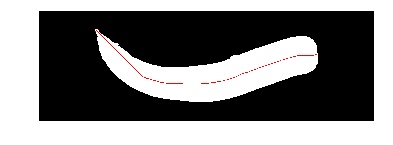

In [9]:
# スケルトンと
def skelOnimg(skeldata,bwimg):
    shape = (bwimg.shape[0],bwimg.shape[1],3)
    img = cv2.merge((bwimg,bwimg,bwimg))
    for i in range (len(skeldata)):
        cv2.circle(img,(int(skeldata[i][0]),int(skeldata[i][1])),3,(0,0,255),-1)
    return img 

# えられたスケルトン上の各点から距離データ分の円を描いて復元した図
# 右側の軸対称でない部分が復元できないが、この方法ではこうなるのは仕方ない
recallimg = skelOnimg(skeldata,bw)
rdl.plotimg(recallimg)
plt.show()


In [10]:
skd = skeldata
# 黒画素から最も距離のある，内部の点を基準点として選ぶ
normP = np.argmax(skd[:,2])
xnorm = skd[normP][0]
ynorm = skd[normP][1]
print ("基準点", xnorm,ynorm)
print(np.max(skd[:,0]), np.max(skd[:1]))
print(normP)

基準点 2700.0 475.0
2907.0 593.0
2108


In [11]:
# 基準点からの距離の配列を生成
distance = np.array([np.sign(x-xnorm)*np.sqrt((x-xnorm)**2 + (y - ynorm)**2)  for (x,y) in skd[:,0:2]] ) 
# 縦向きの画像の場合は sign(y-ynom) ，横ならば sign(x-xnorm)

#基準点からの距離でインデックスを並べ替え
index = np.argsort(distance) # 距離順にインデックスを並べ替え
skd = skd[index] # スケルトンデータを距離順に並べ替え
distance = distance[index] # 距離データも並べ替え
skdp = np.array([list(np.append(s,d)) for (s,d) in zip(skd,distance)])
# skpd はスケルトンの(x座標,y座標,輪郭までの距離,基準点からの距離)のリスト

#  並べ替えたので基準点のインデックスを再度調べ直す
normP = np.argmax(skd[:,2])
print (u'基準点',normP,'(',xnorm,ynorm,')')

基準点 2108 ( 2700.0 475.0 )


（解説）径の一番太い位置の中心を基準点 normP として選び、その点からの距離でスケルトン画素を並べ換える。
もしスケルトンが直線状に並んでいるのならば求めた距離は中心軸に沿った距離に等しいが、湾曲している場合、
基準点からの直線距離と軸に沿って測った距離は基準から離れるほどズレが生じてくる。

形状を評価する場合、湾曲を補正した形状を求める必要があるが、それには直線距離ではなく、
軸に沿って測った距離を使うほうが適切である。

理屈の上では軸に沿って距離を積分、つまり積算していけばよいが、デジタル画像の場合近い点の距離は誤差が大きい。
例えば斜め45度に並ぶ点列の距離は1点ずつ距離を積算してしまうと実際の距離のルート２倍になってしまう。

そこで、曲がりが少ないであろう、１０点ごとに距離を測る基準点を設定し、
（基準点間距離＋最寄りの基準点からの距離）で、軸に沿った距離を近似する。

In [12]:
rdl.recalcDistanceP(skdp,normP)

左側修正量 242.07708231381775 (-2122.016258184654 -> -2364.0933404984717)
右側修正量 5.036900713735008 (208.50419660045213 -> 213.54109731418714)


/Users/dan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  # Remove the CWD from sys.path while we load stuff.
/Users/dan/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/dan/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/Users/dan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clear

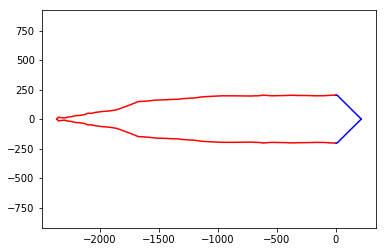

In [13]:
# @interact(invert=False)
def radiusfunc(invert=True):
    if invert:
        for d in skdp: d[3]=-d[3]
    skdN = skdp[skdp[:,3]<= 0] # 基準点より左のデータ
    skdP = skdp[skdp[:,3] > 0] # 基準点より右のデータ
    
    # 横軸を基点からのスケルトン位置までの距離，縦軸をそのスケルトンの距離データとしたグラフ                          
    plt.axis('equal')    
    plt.hold(True)
    ydata = np.array(skdN[:,2])
    xdata = np.array(skdN[:,3])
    plt.plot(xdata,ydata,'-',color=(1,0,0.0))
    plt.plot(xdata,-ydata,'-',color=(1,0,0.0))
    ydata = np.array(skdP[:,2])
    xdata = np.array(skdP[:,3])
    plt.plot(xdata,ydata,'-',color=(0,0,1.0))
    plt.plot(xdata,-ydata,'-',color=(0,0,1.0))
    plt.hold(False)
    plt.show()
    
    
    # invert で再描画する際には、グラフの描画を一旦停止すること。
    # 停止しないと描画されないので注意。
    
radiusfunc(invert=False)


中心軸の画素数=2317


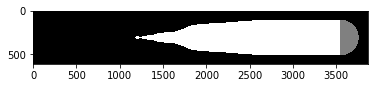

In [14]:
# 中心線を直線化して形状整形した画像の生成
norzimg = rdl.makeNormalizedImage(skdp)
rdl.plotimg(norzimg)

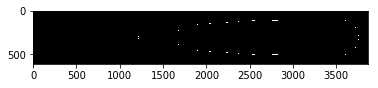

In [15]:
# 輪郭線の抽出
bw,cnt = rdl.getContour(norzimg,0)
cv2.drawContours(bw, cnt, 0, (255,255,255), 1)
rdl.plotimg(bw)

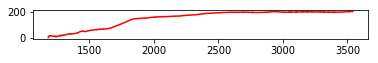

In [16]:
# 先端部分だけの点列の生成
bw,cnt = rdl.getContour(norzimg,2)
xdata = [i[0][0]  for i in cnt[0]]
ydata = [i[0][1]- bw.shape[0]/2 for i in cnt[0]] 
plt.gca().set_aspect('equal',adjustable='box')
plt.plot(xdata,ydata,"r")

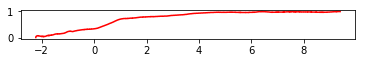

In [17]:
# 最大径を基準に正規化
xdataR = np.array(xdata)/maxR 
ydataR= np.array(ydata)/maxR
xdataR,ydataR = rdl.shiftX(xdataR,ydataR,1/3)    # y = 1/3 付近が x=0 になるようにデータ全体をｘ軸に沿ってシフト
plt.gca().set_aspect('equal',adjustable='box')
plt.plot(xdataR,ydataR,"r")

In [18]:
from fit1 import fit1
fit1((xdataR,ydataR),itr = 2000, alpha=1.0, xmin=-3, xmax=1,cutoff=0.2)

# 原因はわからないが，１度目は描画に失敗するようである．２回目はうまくいく．

AttributeError: module 'tensorflow' has no attribute 'sub'